In [2]:
%load_ext autoreload
%autoreload 2

# Getting the data

In [3]:
import os, sys
from helpers.highlevel_sceneloader import HighLevelSceneLoader
from predictors.dataset_creator import TFDataSet
import tensorflow as tf
from predictors.dl_trainer import DLTrainer 
from predictors.extended_predictor import extended_predictor 
import matplotlib.pyplot as plt
import pickle
from helpers.graph import Graph
import numpy as np

import warnings
warnings.filterwarnings('ignore')


''' set some parameters '''
# Model parameters
LSTM_LAYER_SIZE = 32
DENSE_LAYER_SIZE = 32
NUM_LSTM_LAYERS = 2
NUM_DENSE_LAYERS = 2
VARIABLE_INPUT_LENGTH = False

# Dataset
SEQ_IN_LEN = 3
SEQ_OUT_LEN = 4
NOISE_STD = .1
N_REPEATS = 1

BATCH_SIZE = 5
LENGTH_STRIDE = 2


# Training parameters
MAX_EPOCHS = 100
PATIENCE = 10

# For graph
GRAPH_DIST_THRESH = 4

''' get the data '''
ROOT = os.getcwd()

rel_p_img_b = 'helpers/analysed_vars_storage/img_bounds.xml'
rel_p_dests = 'helpers/analysed_vars_storage/destination_locations.xml'
p_img_bounds = os.path.join(ROOT, rel_p_img_b)
p_dest_locs = os.path.join(ROOT, rel_p_dests)

#TODO: older version of OpenTraj needed: "git checkout d249ba6951dd0f54b532fbe2ca6edc46b0d7093f"
opentraj_root = os.path.join(ROOT, 'OpenTraj')
root_datasets = os.path.join(ROOT, 'data/path_data')
sys.path.append(opentraj_root) # add package to pythonpath

scene_data = HighLevelSceneLoader(p_img_bounds, p_dest_locs)
scene_data.load_ind(root_datasets, 7, 17)


# ''' create the graph instance '''    
# interest_points = __return_waypoints_ind()
# g = Graph.from_matrices(interest_points, scene_data.destination_matrix, GRAPH_DIST_THRESH, .05)

# df_signals = scene_data.df_to_lst_realxy_mats()
# g.analyse_multiple_full_signals(df_signals, add_to_trams_mat=True)


In [4]:

id_col = 'agent_id'
start_df = scene_data.traj_dataframe.copy()
dest_df = scene_data.traj_dataframe.copy()
dest_df[id_col + 'copy'] = dest_df[id_col].shift(-1)
start_df[id_col + 'copy'] = start_df[id_col].shift(1)
dest_df = dest_df.loc[dest_df[id_col]!=dest_df[id_col + 'copy']]
start_df = start_df.loc[start_df[id_col]!=start_df[id_col + 'copy']]
full_df = start_df.append(dest_df)

In [6]:
full_df.head()

,index,frame_id,agent_id,pos_x,pos_y,vel_x,vel_y,label,scene_id,timestamp,agent_idcopy
0,132529,72,9,70.35622,-40.84227,1.11722,-0.96326,pedestrian,1-07,2.88,NaN
10,135964,1044,24,61.03713,-11.80495,-1.31555,0.11735,pedestrian,1-07,41.76,9.0
21,136371,1260,25,50.04138,-13.88356,-1.23642,-0.45302,pedestrian,1-07,50.40,24.0
35,137855,2232,31,25.72032,-7.30970,1.02310,-0.98038,pedestrian,1-07,89.28,25.0
67,139148,2268,33,26.24682,-9.68436,1.06534,-1.10594,pedestrian,1-07,90.72,31.0


In [7]:
d = dest_df[["pos_x", "pos_y"]].to_numpy()
s = start_df[["pos_x", "pos_y"]].to_numpy()

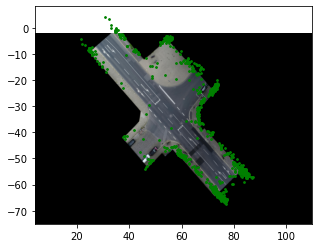

In [11]:
scene_data.plot_on_image([d],colors = ["green"])

# Clustering

In [13]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [44]:
def plot_clustered_elements(d, n_clusters):
    scaler_d = StandardScaler()
    scaled_d = scaler_d.fit_transform(d)

    kmeans_d = KMeans(
        init="random",
        n_clusters=n_clusters,
        n_init=3*n_clusters,
        max_iter=30000,
        random_state=42)

    kmeans_d.fit(scaled_d)
    kmeans_d_pred = scaler_d.inverse_transform(kmeans_d.cluster_centers_)

    return scene_data.plot_on_image([d, kmeans_d_pred],colors = ["green", "yellow"])


## Destinations

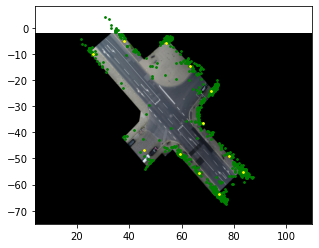

In [45]:
plot_clustered_elements(d, 12)

## Starting points

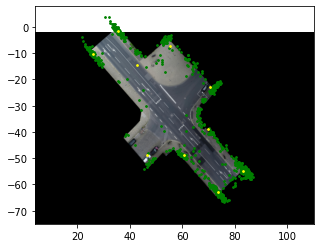

In [47]:
plot_clustered_elements(s, 10)

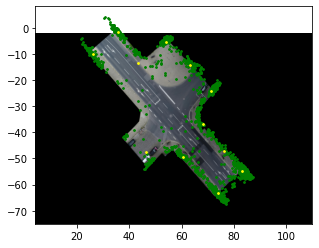

In [53]:
ds = np.concatenate([d,s], axis = 0)
plot_clustered_elements(ds, 12)

## Guess the number of clusters

### Elbow

In [59]:
from yellowbrick.cluster import KElbowVisualizer

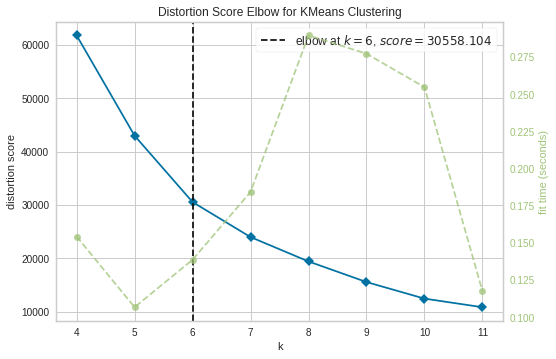

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [60]:
def elbow(d):
    visualizer = KElbowVisualizer(KMeans(), k=(4,12))

    visualizer.fit(d)        # Fit the data to the visualizer
    return visualizer.show()        # Finalize and render the figure
elbow(d)

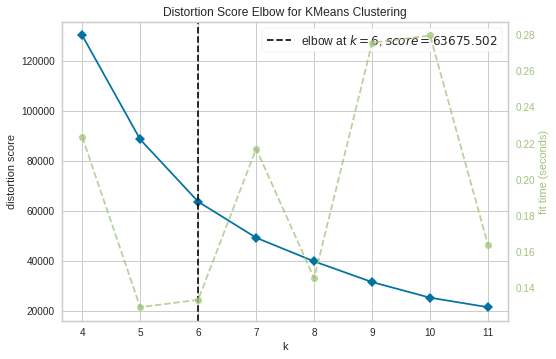

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [62]:
elbow(ds)

### Silhouette Score

In [67]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

range_n_clusters = list(range(4,14))           # clusters range you want to select
dataToFit = d  # sample data
best_clusters = 0                       # best cluster number which you will get
previous_silh_avg = 0.0

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(dataToFit)
    silhouette_avg = silhouette_score(dataToFit, cluster_labels)
    if silhouette_avg > previous_silh_avg:
        previous_silh_avg = silhouette_avg
        best_clusters = n_clusters

# Final Kmeans for best_clusters
kmeans = KMeans(n_clusters=best_clusters, random_state=0).fit(ds)
best_clusters

12

### Method 3?